# ----------------------- Weather Forecast vs Weather Observations -----------------------

In this notebook we want to guide you through the proper use of predictor candidates in the case where you have both observations and forecasted values available.
A prime example of such predictor candidates is weather data. In many cases, weather data has a large impact on the target that you are looking to make predictions for.
In this data you have weather observations that have been actually measured and are usually available in real time up until the moment of forecasting.
  
In time-series analysis it can be very useful to include values throughout the forecasting horizon. In the case of weather you usually have forecasts available that you can add in the data set. These forecasts are hopefully closely aligned with the observed values. The better the quality of the weather forecast, the more useful it will be to include in your time series experiment.  
  
Imagine the use case where you make predictions on a daily basis. If you include weather forecasts, you can store those forecasted values and create a table of historical weather forecasts. The question is often asked: "Is it better to train a model on historical weather observations or historical weather forecasts?" The idea being that the model gets accustomed to using weather forecasts and will provide better results since it uses these values throughout the forecasting horizon.  
Here we will outline the best way of using weather observations and forecasts. To get a quick anwser to our question we will prepare 5 data sets outlining 5 different scenarios and use TIM for forecasting. With TIM you will easily learn the effect of using observations and/or forecasts and even get insights why.

# 0. Setup

Import the TIM Python Client and supporting Python libraries and authenticate by providing TIM with your license credentials. 

In [57]:
from tim import Tim
import pandas as pd
import json
import time
import datetime as dt
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('mode.chained_assignment', None)
from IPython.display import clear_output

In [2]:
tim_credentials = json.load(open('tim_credentials.json'))
client = Tim(email=tim_credentials['email'],password=tim_credentials['password'])

# 1. Data Preparation

We will use data from the Belgian Electricity Grid as the target value to predict. This information is sourced from https://www.entsoe.eu/. The weather data is sourced from https://openweathermap.org/ where we have collected both weather observations and forecasts in the weather dataset below. The grid data and weather data are combined in various ways to simulate the scenarios below.

In [3]:
grid_df = pd.read_csv('belgian_grid_data.csv', low_memory=False)
weather_df = pd.read_csv('weather_data.csv', low_memory=False)
weather_variables = ['temp','feels_like','pressure','humidity','wind_speed','wind_deg','rain','snow','clouds']
fc_weather_variables = ['fc_' + sub for sub in weather_variables]

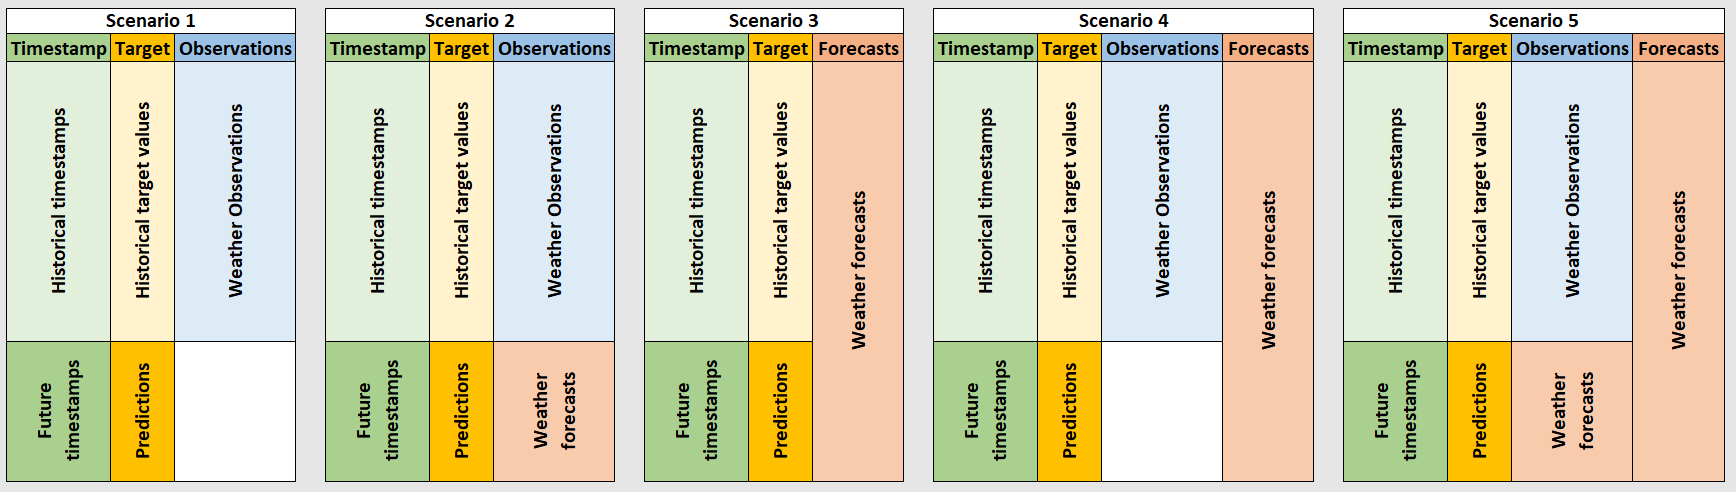

We will prepare 5 different datasets to learn what the effect is of having either weather observations or weather forecast as training data.
Below, the following scenarios are described:
- __Scenario 1: Only Weather observations:__  
We add this scenario as a benchmark for the others. In this base case, we provide TIM with only weather observations meaning it has no predictor candidate values available throughout the forecasting horizon. This means that it will need to build models using offsets of the target and predictor candidates.
- __Scenario 2: Weather observations supplemented with weather forecasts:__  
From the base case in scenario 1 we add weather forecasts into the same columns as the weather observations. This way TIM can learn on observed data and use weather forecasts as added information througout the forecasting horizon.
- __Scenario 3: Only Weather forecasts:__  
Scenario 3 compares mostly to scenario 2 since here we will train on historical weather forecasts instead of observed weather data. The hypothesis is that by training on forecasts, TIM will build a model that is accustomed to weather forecasts and will therefore be able to generate better results than training on observed data. 
- __Scenario 4: Include all available data:__  
You could also combine scenario 1 & 3 together and provide TIM with all available data. It will be able to train on both weather forecasts and weather observations.
- __Scenario 5: Include all available data and supplement weather forecasts to observations:__  
This is a variation on scenario 4, however now such as in scenario 2 we will supplement the columns with observed weather data with weather forecasts. This means that the values in the observations columns and the forecast columns will be the same for the future timestamps. The reason for this is that we will tell TIM that it has future values available for all columns and will not only have to rely on offsets for the observed values such as in scenario 4.

In [4]:
# ------------------------------------------------------------  scenario 1 ------------------------------------------------------------
pre_scenario_1_df = grid_df.merge(weather_df[['Timestamp']+weather_variables],on='Timestamp',how='left')
scenario_1_df = pre_scenario_1_df[(pre_scenario_1_df['Timestamp']>='2021-01-27 00:00:00')&(pre_scenario_1_df['Timestamp']<='2022-03-07 23:00:00')]
# ------------------------------------------------------------  scenario 2 ------------------------------------------------------------
historical_weather_df = weather_df[(weather_df['Timestamp']>='2021-01-27 00:00:00')&(weather_df['Timestamp']<='2022-03-07 23:00:00')][['Timestamp']+weather_variables]
future_weather_df = weather_df[(weather_df['Timestamp']>'2022-03-07 23:00:00')&(weather_df['Timestamp']<='2022-03-08 23:00:00')][['Timestamp']+fc_weather_variables]
future_weather_df.columns = historical_weather_df.columns.values
pre_scenario_2_df = grid_df[(grid_df['Timestamp']>='2021-01-27 00:00:00')&(grid_df['Timestamp']<='2022-03-07 23:00:00')].merge(pd.concat([historical_weather_df,future_weather_df]),on='Timestamp',how='outer')
scenario_2_df = pre_scenario_2_df[(pre_scenario_2_df['Timestamp']>='2021-01-27 00:00:00')&(pre_scenario_2_df['Timestamp']<='2022-03-08 23:00:00')]
# ------------------------------------------------------------  scenario 3 ------------------------------------------------------------
pre_scenario_3_df = grid_df[(grid_df['Timestamp']>='2021-01-27 00:00:00')&(grid_df['Timestamp']<='2022-03-07 23:00:00')].merge(weather_df[['Timestamp']+fc_weather_variables],on='Timestamp',how='outer')
scenario_3_df = pre_scenario_3_df[(pre_scenario_3_df['Timestamp']>='2021-01-27 00:00:00')&(pre_scenario_3_df['Timestamp']<='2022-03-08 23:00:00')]
# ------------------------------------------------------------  scenario 4 ------------------------------------------------------------
pre_scenario_4_df = grid_df[(grid_df['Timestamp']>='2021-01-27 00:00:00')&(grid_df['Timestamp']<='2022-03-07 23:00:00')].merge(weather_df[['Timestamp']+weather_variables],on='Timestamp',how='left').merge(weather_df[['Timestamp']+fc_weather_variables],on='Timestamp',how='outer')
scenario_4_df = pre_scenario_4_df[(pre_scenario_4_df['Timestamp']>='2021-01-27 00:00:00')&(pre_scenario_4_df['Timestamp']<='2022-03-08 23:00:00')]
# ------------------------------------------------------------  scenario 5 ------------------------------------------------------------
scenario_5_df = scenario_2_df.merge(scenario_3_df.drop(columns='Quantity'),on='Timestamp',how='left')

You can use the code below to visualize any of these 5 scenarios.

In [5]:
tim_input_df = scenario_4_df.copy()
timestamp = 'Timestamp'
target_variable = 'Quantity'
predictor_candidates = [s for s in list(tim_input_df.columns) if s not in [timestamp,target_variable]]
tim_input_df = tim_input_df[[timestamp,target_variable]+predictor_candidates].reset_index(drop=True)

In [ ]:
tim_input_df.tail(30)

In [ ]:
v_data = tim_input_df.copy()
fig = plt.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=v_data[timestamp], y=v_data[target_variable], name=target_variable), row=1, col=1)
for idx, p in enumerate(predictor_candidates):
    fig.add_trace(go.Scatter(x=v_data[timestamp], y=v_data[p], name=p), row=2, col=1)
fig.update_layout(height=600, width=1200, title_text="Data visualization")
fig.show()    

# 2. TIM Setup

In this section we set the configuration for TIM. In this experiment, we will use default settings of TIM and make sure all 5 scenarios analyze the same data and generate output for the same timestamps for an honest comparison. In this case, we'll build models that are capable of looking 24 samples ahead. The data has an hourly sampling rate therefore we forecast 1 day ahead. To test the accuracy, we'll set the number of out of sample rows to 8 weeks worth of samples. (24 x 7 x 8 samples). This data will not be used in the training process. TIM will keep that data for testing so that we can validate the models performances. All other potential settings are commented out (#). If not provided TIM will assume default settings for these parameters. For more information on configuration setting, you can visit our documentation here: https://docs.tangent.works/TIM-Platform/TIM-Forecasting/Configuration/Overview/

In [8]:
predictionTo = 24
outOfSampleRows = 24*7*8

In [9]:
job_configuration = {
#             "name": "My first forecast job",
#             "useCase": {"id":"useCaseId"},
#             "experiment": {"id":"experimentId"},
            "configuration": {
                "predictionTo": {"baseUnit": "Sample","value": predictionTo},
#                "predictionFrom": {"baseUnit": "Sample","value": 1},
#                "modelQuality": "Medium",
#                 "normalization": True,
#                 "maxModelComplexity": 50,
#                 "features": [
#                    "ExponentialMovingAverage",
#                     "RestOfWeek",
#                     "Periodic",
#                     "Intercept",
#                     "PiecewiseLinear",
#                     "TimeOffsets",
#                     "Polynomial",
#                     "Identity",
#                     "PublicHolidays",      
# #                     "SimpleMovingAverage",
# #                     "Month",
# #                     "Trend",
# #                     "DayOfWeek",
# #                     "Fourier",
#                     ],
#                 "dailyCycle": False,
#                 "allowOffsets": True,
#                 "offsetLimit": {"type": "Explicit","value": 0},
#                 "memoryLimitCheck": True,
#                  "predictionIntervals": 90,
#                  "predictionBoundaries": {"type": "Explicit",
#                      "maxValue": 750,
#                     "minValue": 100
#                      },
#                 "rollingWindow": {"baseUnit": "Sample","value": 1},
#                 "backtest": "All"
                },
            "data": {
#                 "version": {"id":"versionId"},
#                 "inSampleRows": {"baseUnit": "Sample","value": 1},
                "outOfSampleRows": {"baseUnit": "Sample","value": outOfSampleRows}, #{"baseUnit": "Sample","value": outOfSampleRows} or [{"from": "yyyy-mm-dd HH:MM:SS","to": "yyyy-mm-dd HH:MM:SS"}]
#                "imputation": {"type": "Linear","maxGapLength": 1000},
#                 "columns": [
#                     1,
#                     3,
#                     "wind"
#                     ],
#                 "targetColumn": "y",
#                 "holidayColumn": holidayColumn,
#                 "timeScale": {"baseUnit": "Hour","value": 1},
#                 "aggregation": "Mean"
                }
            }

Below is the configuration that will be sent to TIM in each of the 5 experiments.

In [ ]:
job_configuration

### Helper Functions

In [24]:
def get_forecast_job_results_accuracy(response):   
    bin_json = response['bin']
    bin_accuracy_df = pd.DataFrame()
    for n in bin_json:
        bin_accuracy_df = pd.concat([bin_accuracy_df,pd.DataFrame(n).reset_index().rename(columns={'index':'KPI'})])
    bin_accuracy_df['accuracy_type'] = 'bin'

    samplesAhead_json = response['samplesAhead']
    samplesAhead_accuracy_df = pd.DataFrame()
    for n in samplesAhead_json:
        samplesAhead_accuracy_df = pd.concat([samplesAhead_accuracy_df,pd.DataFrame(n).reset_index().rename(columns={'index':'KPI'})])
    samplesAhead_accuracy_df['accuracy_type'] = 'samplesAhead'

    all_accuracy_df = pd.DataFrame(response['all']).reset_index().rename(columns={'index':'KPI'})
    all_accuracy_df['accuracy_type'] = 'all'
    id_columns = ['KPI','name','accuracy_type']
    acc_df = pd.concat([all_accuracy_df,samplesAhead_accuracy_df,bin_accuracy_df])
    df = pd.melt(acc_df, id_vars=id_columns, value_vars=list(set(acc_df.columns)-set(id_columns)))
    return df

def get_forecast_job_results_model(response):
    properties = response['model']['modelZoo']['variableProperties']
    models = response['model']['modelZoo']['models']
    
    pi_df = pd.DataFrame(properties).sort_values(by='importance',ascending=False)
    pi_df['rel_importance'] = pi_df['importance']/pi_df.sum()['importance']
    
    features = []
    for m in models:
        terms = m['terms']
        for count,t in enumerate(terms):
            f,b = find_feature(t['parts'])
            features.append([m['index'],count,f,t['importance'],b])
    fi_df = pd.DataFrame(features,columns=['Model','Term','Feature','importance','beta'])
    return pi_df,fi_df,models

def find_feature(sub_parts):
    dow_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    month_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
    features_list = []
    for c,s in enumerate(sub_parts):
        if   s['type']=='β':
            sub_feature = ''
        elif s['type']=='TimeOffsets':
            sub_feature = s['predictor']+'(t'+str(s['offset'])+')'
        elif s['type']=='RestOfWeek':
            sub_feature ='DoW(t'+str(s['offset'])+') <= '+dow_list[s['day']-1]
        elif s['type']=='Intercept':
            sub_feature = 'Intercept('+str(int(s['value']))+')'
        elif s['type']=='Cos':
            sub_feature = 'Cos('+str(int(s['period']))+';'+s['unit']+')'
        elif s['type']=='Sin':
            sub_feature = 'Sin('+str(int(s['period']))+';'+s['unit']+')'
        elif s['type']=='ExponentialMovingAverage':
            sub_feature = 'EMA_'+s['predictor']+'(t'+str(int(s['offset']))+'; w='+str(int(s['window']))+')'
        elif s['type']=='Identity':
            sub_feature = s['predictor']
        elif s['type']=='PiecewiseLinear':
            sub_feature = 'max(0;'+str(s['subtype'])+'*('+str(round(s['knot'],6))+'-'+s['predictor']+'(t'+str(s['offset'])+')))'
        elif s['type']=='SimpleMovingAverage':
            sub_feature = 'SMA_'+s['predictor']+'(t'+str(int(s['offset']))+'; w='+str(int(s['window']))+')'
        elif s['type']=='Fourier':
            sub_feature = 'Fourier('+str(s['period'])+')'
        elif s['type']=='Weekday':
            sub_feature = 'DoW(t'+str(s['offset'])+') = '+dow_list[s['day']-1]
        elif s['type']=='Month':
            sub_feature = 'Month<='+month_list[s['month']]
        elif s['type']=='PublicHolidays':
            sub_feature = s['predictor']
        elif s['type']=='Trend':
            sub_feature = 'Trend'
        else:
            sub_feature = '_test_'
        if s['type']=='β':
            features_list.append(sub_feature)
            beta = s['value']
        else:
            features_list.append(' & '+sub_feature) if c>0 else features_list.append(sub_feature)
    feature_output = ''.join(str(e) for e in features_list)
    return feature_output,beta

# 3. API Call

In this section the API calls to TIM are made. There are many possible set ups to send your experiments to TIM. In this example we'll first upload the datasets for each scenario. Then we'll register the forecasting jobs for each scenario. Next, requests are made to execute these jobs, which allows them to run in parallel. Lastly, we check if the jobs are finished. 

1. Upload the datasets

In [ ]:
tim_datasets = ["scenario_1_df","scenario_2_df","scenario_3_df","scenario_4_df","scenario_5_df"]
datasets = []
for ds in tim_datasets:
    tim_input_df = globals()[ds].copy()
    dataset_configuration = {"name": ds}
    dataset_response = client.upload_dataset(dataset=tim_input_df,configuration=dataset_configuration,handle_status_poll=print)
    dataset_id = dataset_response[0]['id']
    datasets.append({'dataset_name':ds,'dataset_id':dataset_id})

2. Register the forecasting jobs

In [ ]:
jobs = []
for ds in datasets:
    dataset_id = ds['dataset_id']
    job_name = ds['dataset_name']
    build_model_response = client.build_forecasting_model(dataset_id=dataset_id,job_configuration=job_configuration)
    jobs.append({'job_name':job_name,'job_id':build_model_response})
    print(job_name)

3. Execute the forecasting jobs

In [ ]:
for j in jobs:
    try:
        forecast_job_id = j['job_id']
        job_execute_response = client.execute_forecast(forecast_job_id=forecast_job_id,wait_to_finish=False,handle_status_poll=print)
    except:
        pass
    print(j['job_name'],job_execute_response)

4. Check the progress

In [ ]:
job_ids = []
for j in jobs: job_ids.append(j['job_id'])
open_check = [1]
idx = 0
while (len(open_check)>0 or idx>100):
    clear_output(wait=True)
    requests_df = pd.DataFrame(client.get_forecasting_jobs(limit=100))
    experiment_requests_df = requests_df[requests_df['id'].isin(job_ids)]
    open_check = list(set(list(experiment_requests_df['status'].unique())).intersection(['Registered','Queued','Running']))
    idx =+ 1
    print(experiment_requests_df.groupby('status').count()[['id']],print(idx))
    time.sleep(2)

# 4. Collect Results

After completion of the TIM experiments we can collect the results from the engine and post-process them into useful tables for visualization or other purposes.

In [ ]:
job_responses = jobs.copy()
for j in job_responses:
    forecast_job_id = j['job_id']
    forecast_response = client.get_forecast_results(forecast_job_id=forecast_job_id)
    j['forecast_response'] = forecast_response
    print(j['job_name'])

In [18]:
all_results_df = pd.DataFrame()
for j in job_responses:
    forecast_job_results_table_df = j['forecast_response'][2]
    for i in forecast_job_results_table_df['forecast_type'].unique(): forecast_job_results_table_df.loc[forecast_job_results_table_df['forecast_type']==i, i] = forecast_job_results_table_df['forecast']
    forecast_job_results_table_df['job_name'] = j['job_name']
    all_results_df = pd.concat([all_results_df,forecast_job_results_table_df])

all_properties_df = pd.DataFrame()
all_features_df = pd.DataFrame()
for j in job_responses:
    properties_df,features_df,model = get_forecast_job_results_model(j['forecast_response'][1])
    properties_df['job_name'] = j['job_name']
    features_df['job_name'] = j['job_name']
    all_properties_df = pd.concat([all_properties_df,properties_df])
    all_features_df = pd.concat([all_features_df,features_df])

all_accuracy_df = pd.DataFrame()
for j in job_responses:
    accuracy_df = get_forecast_job_results_accuracy(j['forecast_response'][3])
    accuracy_df['job_name'] = j['job_name']
    all_accuracy_df = pd.concat([all_accuracy_df,accuracy_df])

We collect the OutOfSample results and manually calculate the MAE and cumulative MAE. TIM will already provide us with metrics to validate the accuracy of the models but in this case we calculate more metrics manually for visualization purposes. 
  
For more information about backtesting please visit our documentation here:  
https://docs.tangent.works/TIM-Platform/TIM-Forecasting/How-it-works/Backtesting/#understanding-the-in-sample-and-out-of-sample-settings

In [19]:
simulation_df = all_results_df[all_results_df['forecast_type']=='OutOfSample']
simulation_df['MAE'] = abs(simulation_df['forecast']-simulation_df['target'])
simulation_df['Cumulative_MAE'] = simulation_df.groupby(['job_name']).cumsum()['MAE']
simulation_pivot_df = simulation_df.pivot(index=['timestamp','target'], columns='job_name', values=['forecast','MAE','Cumulative_MAE']).reset_index()
simulation_pivot_df.columns = ['_'.join(col[::-1]).strip() for col in simulation_pivot_df.columns.values]

# 5. Visualize Results

In the interactive image below you can find the original target value as well as the forecasted values, the MAE and Cumulative MAE for each of the 5 scenarios.  
The MAE lines (Mean Absolute Average) indicates the absolute error between the forecast and the target values. Usually you would then take the mean value of all theses absolute errors and that would be your accuracy metric. In this case we visualize the absolute errors over the timestamps to get a better understand of how each scenario behaves.  
The cumulative MAE is simply the cumulative sum of the MAE values and this helps us show which scenario performs better over time.

In [ ]:
v_data = simulation_pivot_df.copy()
x_axis = '_timestamp'
colors = ['blue','red','gold','green','purple']
fig = plt.subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.02,shared_xaxes=True)
fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data['_target'], name='target', line=dict(color='black')), row=1, col=1)
for c,p in enumerate(jobs):
    fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p['job_name']+'_forecast'], name=p['job_name']+'_forecast', line=dict(color=colors[c])), row=1, col=1)
    fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p['job_name']+'_MAE'], name=p['job_name']+'_MAE', line=dict(color=colors[c])), row=2, col=1)
    fig.add_trace(go.Scatter(x=v_data[x_axis], y=v_data[p['job_name']+'_Cumulative_MAE'], name=p['job_name']+'_Cumulative_MAE', line=dict(color=colors[c])), row=3, col=1)    
fig.update_layout(height=800, width=1400, title_text="Simulation Results")
fig.show()

The accuracy metrics that TIM calculates and provides automatically are visualize below for each of the scenarios.  
Both in & out of sample values are presented. The focus here lies on out of sample results where we compare forecasted values to actual values which were not used in the model building but are available to test the performance of the model on data it has not seen before.

In [ ]:
rows = all_accuracy_df.dropna()['variable'].unique()
columns = all_accuracy_df.dropna()['KPI'].unique()
subplot_titles = []
for i in rows:
    for j in columns: subplot_titles.append(str(i)+" "+str(j))
fig = plt.subplots.make_subplots(rows=len(rows), cols=len(columns), vertical_spacing=0.2,subplot_titles=subplot_titles)
for r,i in enumerate(rows):
    for c,j in enumerate(columns):
        v_data = all_accuracy_df[(all_accuracy_df['accuracy_type']=='all')&(all_accuracy_df['variable']==i)&(all_accuracy_df['KPI']==j)]
        fig.add_trace(go.Bar(x=v_data['job_name'], y=v_data['value'], name=str(i)+" "+str(j),text=round(v_data['value'],2),textposition='auto'), row=r+1, col=c+1)
fig.update_layout(height=800, width=1400, title_text="Accuracy visualization")
fig.show()

In the properties below you can see which columns from the dataset has been used in each scenario. From this we can learn how TIM is responding to the different predictor candidates available and combined with the results above interesting insights can be gathered on which columns to use and which not in further experiments.

In [ ]:
fig = px.bar(all_properties_df, x="job_name", y="rel_importance", color="name")
fig.update_layout(height=500, width=1400, title_text="Properties")
fig.show()

# 6. Conclusions

__Winning Scenario__  
The accuracy measures indicate that scenario 2 is the clear winner in this use case. It seems that training a model on observations and supplementing those with forecasts is comparatively better than using only forecasts (scenario 3). Weather forecasts inherently contain errors and this experiment shows that models should not be trained on such data with the idea that it might learn how to take those errors into account. It is clearly better to find the real relationships between the datapoints and then supplement the data with any available data for predicting. 

__Using forecasts as predictor candidates__  
This experiment also outlines the importance of using those forecast in addition to observations. When we compare scenario 1 & 2, we can clearly see that adding those forecasts in the data set has a significant positive effect on the results. Taking into account data availability is clearly quite important in time series modeling and having those predictor candidates available throughout the prediction horizon will almost always have this effect. Luckily, TIM is easily capable of tackling both scenarios in case your particular use case doesn't allow for such data availability.

__Prone to error spikes__  
In the graph above, you can see the MAE and cumulative MAE visualized. Looking at the MAE, we can see that the scenarios which rely heavily on forecasts are far more prone to error spikes (sudden outliers in MAE). This proves again that "garbage-in" means "garbage-out" and if the quality of the forecasts is bad, the model will react heavily on that. 
The cumulative MAE chart shows the performance of each model over time. From this we learn that scenario 2 consistently outperforms the other scenarios.

__Adding too much information__  
Interestingly scenario 4 & 5 don't have better results, even though they have all the information of scenario 2 and more in their data sets. From the model importances we can find out that adding too much information based on forecasts, which contains these errors, will force TIM to go through those and create features based on those factors. We can see that for InSample results the accuracies are closely aligned. However when we test this out on OutOfSample data we can see that scenario 2 outperforms the scenarios 4 & 5. This indicates that providing TIM with forecasts, leads it to learn the wrong things. Therefore it is best to focus TIM's efforts on good data to get most out of your use case.

__Using TIM for forecasting__

Lastly, conducting this experiment with TIM is very straight forward with this template. This shows how you can easily analyze and compare different datasets in a matter of minutes.
From there you can quickly make your conclusions and move on to working on the next items in your value chain. TIM can accelerate your experiments significantly and get you to business value as soon as possible.

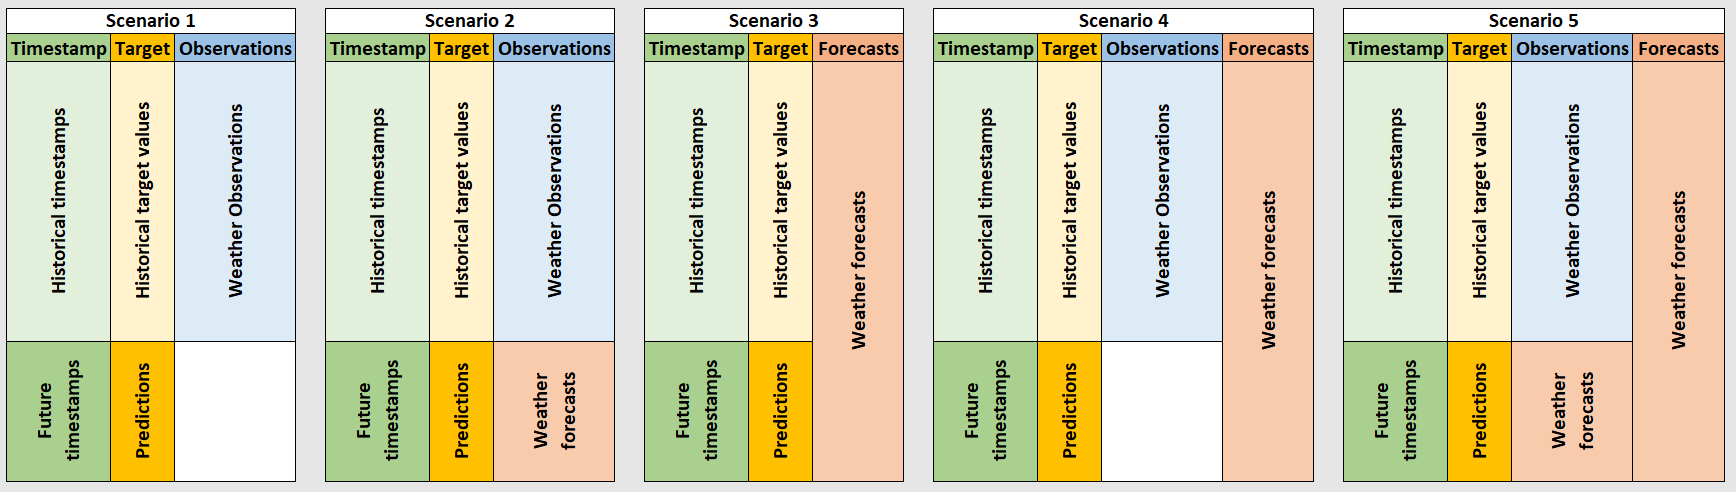